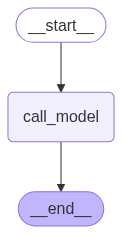

In [ ]:
from langchain.chat_models import init_chat_model
from langchain_core.messages.utils import count_tokens_approximately, trim_messages
from langgraph.checkpoint.memory import InMemorySaver
from langgraph.graph import START, MessagesState, StateGraph

model = init_chat_model("azure_openai:gpt-4o")
summarization_model = model.bind(max_tokens=128)


def call_model(state: MessagesState):
    messages = trim_messages(
        state["messages"],
        strategy="last",
        token_counter=count_tokens_approximately,
        max_tokens=128,
        start_on="human",
        end_on=("human", "tool"),
    )
    response = model.invoke(messages)
    return {"messages": [response]}


checkpointer = InMemorySaver()
builder = StateGraph(MessagesState)
builder.add_node(call_model)
builder.add_edge(START, "call_model")
graph = builder.compile(checkpointer=checkpointer)
graph

In [5]:
config = {"configurable": {"thread_id": "1"}}
graph.invoke({"messages": "hi, my name is bob"}, config)
graph.invoke({"messages": "write a short poem about cats"}, config)
graph.invoke({"messages": "now do the same but for dogs"}, config)
final_response = graph.invoke({"messages": "what's my name?"}, config)

final_response["messages"][-1].pretty_print()

================================== Ai Message ==================================

I'm sorry, but I don't have access to personal information about individuals unless you share it with me during our conversation. If you'd like to share your name or have any other questions, feel free to let me know!


In [3]:
final_response["messages"]

[HumanMessage(content='hi, my name is bob', additional_kwargs={}, response_metadata={}, id='e8d9ced8-be26-4011-b171-6e083c12205a'),
 AIMessage(content='Hi Bob! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 11, 'prompt_tokens': 13, 'total_tokens': 24, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_ee1d74bde0', 'id': 'chatcmpl-BpXBUIXZlE6FRi6dD02qvDmlTl8jS', 'service_tier': None, 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'jailbreak': {'filtered': False, 'detected': False}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': False, 'severity'

In [ ]:
from langchain_core.messages import RemoveMessage


def delete_messages(state):
    messages = state["messages"]
    if len(messages) > 2:
        # remove the earliest two messages
        return {"messages": [RemoveMessage(id=m.id) for m in messages[:2]]}


def call_model(state: MessagesState):
    response = model.invoke(state["messages"])
    return {"messages": response}


builder = StateGraph(MessagesState)
builder.add_sequence([call_model, delete_messages])
builder.add_edge(START, "call_model")

checkpointer = InMemorySaver()
app = builder.compile(checkpointer=checkpointer)

for event in app.stream(
    {"messages": [{"role": "user", "content": "hi! I'm bob"}]},
    config,
    stream_mode="values",
):
    print([(message.type, message.content) for message in event["messages"]])

for event in app.stream(
    {"messages": [{"role": "user", "content": "what's my name?"}]},
    config,
    stream_mode="values",
):
    print([(message.type, message.content) for message in event["messages"]])

[('human', "hi! I'm bob")]
[('human', "hi! I'm bob"), ('ai', 'Hello, Bob! How can I assist you today?')]
[('human', "hi! I'm bob"), ('ai', 'Hello, Bob! How can I assist you today?'), ('human', "what's my name?")]
[('human', "hi! I'm bob"), ('ai', 'Hello, Bob! How can I assist you today?'), ('human', "what's my name?"), ('ai', "You mentioned that your name is Bob. If there's anything else you'd like to discuss or ask, feel free to let me know!")]
[('human', "what's my name?"), ('ai', "You mentioned that your name is Bob. If there's anything else you'd like to discuss or ask, feel free to let me know!")]
